In [9]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class NSGA2PIRP:
    def __init__(self, retailers, distances, demand, profits, weights, vehicle_capacity,
                 travel_cost_per_km, emissions_per_km, perishability, max_generations=100):
        self.retailers = retailers
        self.distances = distances
        self.demand = demand
        self.profits = profits
        self.weights = weights
        self.vehicle_capacity = vehicle_capacity
        self.travel_cost_per_km = travel_cost_per_km
        self.emissions_per_km = emissions_per_km
        self.perishability = perishability
        self.max_generations = max_generations

    def evaluate(self, individual):
        try:
            inventory_allocation, route = self.decode_individual(individual)

            # Capacity constraint
            total_weight = sum(self.weights[i] * inventory_allocation[i] for i in range(len(self.retailers)))
            excess_weight = max(0, total_weight - self.vehicle_capacity)

            # Perishability constraint
            perishability_penalty = 0
            for i in range(len(self.retailers)):
                if inventory_allocation[i] > 0 and self.perishability[i] <= 0:
                    perishability_penalty += 500

            # Calculate objectives
            total_profit = sum(self.profits[i] * inventory_allocation[i] for i in range(len(self.retailers)))
            travel_cost = sum(self.travel_cost_per_km * self.distances[route[i]][route[i + 1]]
                              for i in range(len(route) - 1))
            emission_cost = sum(self.emissions_per_km * self.distances[route[i]][route[i + 1]]
                                for i in range(len(route) - 1))

            # Normalize objectives
            normalized_profit = total_profit - 5 * excess_weight - perishability_penalty
            normalized_travel_cost = travel_cost / max(self.distances.flatten())
            normalized_emission_cost = emission_cost / max(self.distances.flatten())

            return normalized_profit, normalized_travel_cost, normalized_emission_cost
        except Exception as e:
            print(f"Error in evaluation: {e}")
            return -1e6, 1e6, 1e6

    def decode_individual(self, individual):
        n_retailers = len(self.retailers)
        inventory_allocation = [max(0, min(self.demand[i], abs(individual[i]))) for i in range(n_retailers)]
        route = [0] + sorted(range(1, n_retailers), key=lambda x: individual[n_retailers + x]) + [0]
        return inventory_allocation, route

    def create_toolbox(self):
        n_retailers = len(self.retailers)
        creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0))
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        toolbox = base.Toolbox()
        toolbox.register("attr_inventory", random.uniform, 0, max(self.demand))
        toolbox.register("attr_route", random.uniform, 0, 1)
        toolbox.register("individual", tools.initCycle, creator.Individual,
                         (toolbox.attr_inventory,) * n_retailers + (toolbox.attr_route,) * n_retailers, n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate)
        toolbox.register("mate", tools.cxUniform, indpb=0.7)
        toolbox.register("mutate", tools.mutPolynomialBounded,
                         eta=20.0, low=0.0, up=max(max(self.demand), 1.0), indpb=0.3)
        toolbox.register("select", tools.selNSGA2)
        return toolbox

    def solve(self, pop_size=300, num_generations=300):
        toolbox = self.create_toolbox()
        population = toolbox.population(n=pop_size)

        cxpb = 0.5  # Crossover probability
        mutpb = 0.5  # Higher mutation probability
        lambda_ = pop_size * 3  # Increased offspring population

        for gen in range(num_generations):
            offspring = algorithms.varOr(population, toolbox, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb)
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            introduce_random_immigrants(offspring, toolbox, proportion=0.1)
            population[:] = toolbox.select(population + offspring, pop_size)

        pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
        return pareto_front


def introduce_random_immigrants(population, toolbox, proportion=0.1):
    num_immigrants = int(len(population) * proportion)
    new_individuals = [toolbox.individual() for _ in range(num_immigrants)]
    population[:num_immigrants] = new_individuals





In [11]:
def generate_diverse_test_case(n_retailers):
    np.random.seed(42)
    distances = np.random.randint(50, 1000, size=(n_retailers, n_retailers))
    np.fill_diagonal(distances, 0)
    distances = (distances + distances.T) // 2
    profits = np.random.randint(1000, 2000, size=n_retailers)  # Higher profits
    weights = np.random.randint(5, 20, size=n_retailers)       # Smaller weights
    demand = np.random.randint(5, 20, size=n_retailers)        # Moderate demand
    perishability = np.random.randint(10, 20, size=n_retailers)  # Longer shelf life
    total_possible_weight = sum(weights[i] * demand[i] for i in range(n_retailers))
    vehicle_capacity = int(total_possible_weight * 0.7)  # Larger capacity
    travel_cost_per_km = np.random.randint(5, 10)  # Moderate travel cost
    emissions_per_km = np.random.randint(1, 5)     # Lower emissions
    time_windows = [(0, 24) for _ in range(n_retailers)]
    return distances, profits, weights, demand, perishability, vehicle_capacity, travel_cost_per_km, emissions_per_km, time_windows


In [13]:
import gurobipy as gp
from gurobipy import GRB


class PIRPWithCoSolver:
    def __init__(self, retailers, distances, demand, profits, weights, vehicle_capacity,
                 travel_cost_per_km, emissions_per_km, perishability, time_windows, max_iter=100):
        self.retailers = retailers
        self.distances = distances
        self.demand = demand
        self.profits = profits
        self.weights = weights
        self.vehicle_capacity = vehicle_capacity
        self.travel_cost_per_km = travel_cost_per_km
        self.emissions_per_km = emissions_per_km
        self.perishability = perishability
        self.time_windows = time_windows
        self.max_iter = max_iter

        self.best_profit = -float("inf")
        self.best_route = None
        self.best_inventory = None

    def solve_inventory(self, current_route, current_time, weight_profit=0.5, weight_cost=0.3, weight_emission=0.2):
        """
        Solve the inventory allocation problem with multi-objective weighted optimization.
        """
        n_retailers = len(self.retailers)
        model = gp.Model("Inventory")

        inventory = model.addVars(n_retailers, vtype=GRB.CONTINUOUS, name="inventory", lb=0)

        # Calculate weighted objectives
        travel_cost = gp.quicksum(
            self.travel_cost_per_km * self.distances[current_route[i]][current_route[i + 1]]
            for i in range(len(current_route) - 1)
        )
        emission_cost = gp.quicksum(
            self.emissions_per_km * self.distances[current_route[i]][current_route[i + 1]]
            for i in range(len(current_route) - 1)
        )

        # Weighted objective function
        model.setObjective(
            weight_profit * gp.quicksum(self.profits[i] * inventory[i] for i in range(n_retailers))
            - weight_cost * travel_cost
            - weight_emission * emission_cost,
            GRB.MAXIMIZE
        )

        # Constraints
        model.addConstr(
            gp.quicksum(self.weights[i] * inventory[i] for i in range(n_retailers)) <= self.vehicle_capacity,
            "Capacity"
        )

        for i in range(n_retailers):
            model.addConstr(inventory[i] <= self.demand[i], f"Demand_{i}")
            if current_time > self.perishability[i]:
                model.addConstr(inventory[i] == 0, f"Perishability_{i}")

        model.optimize()

        if model.status == GRB.OPTIMAL:
            return [inventory[i].x for i in range(n_retailers)]
        else:
            print("Inventory allocation infeasible.")
            return []

    def solve_tsp(self, inventory_allocation, weight_cost=0.3, weight_emission=0.2):
        """
        Solve the TSP problem with multi-objective optimization for travel and emissions.
        """
        n_retailers = len(self.retailers)
        model = gp.Model("TSP")

        route = model.addVars(n_retailers, n_retailers, vtype=GRB.BINARY, name="route")

        # Weighted objective: Minimize travel cost and emissions
        model.setObjective(
            gp.quicksum((weight_cost * self.travel_cost_per_km + weight_emission * self.emissions_per_km)
                        * self.distances[i][j] * route[i, j]
                        for i in range(n_retailers) for j in range(n_retailers) if i != j),
            GRB.MINIMIZE
        )

        # Constraints
        model.addConstrs(
            gp.quicksum(route[i, j] for j in range(n_retailers) if i != j) == 1 for i in range(n_retailers)
        )
        model.addConstrs(
            gp.quicksum(route[j, i] for j in range(n_retailers) if i != j) == 1 for i in range(n_retailers)
        )

        model.optimize()

        if model.status == GRB.OPTIMAL:
            tsp_route_tuples = [(i, j) for i in range(n_retailers) for j in range(n_retailers)
                                if i != j and route[i, j].x > 0.5]
            return self.convert_route_to_sequence(tsp_route_tuples, n_retailers)
        else:
            print("TSP infeasible.")
            return []

    def convert_route_to_sequence(self, route_tuples, n_retailers):
        """
        Convert a list of TSP route tuples into a valid sequence.
        """
        sequence = []
        visited = set()
        current = 0

        while len(sequence) < n_retailers:
            sequence.append(current)
            visited.add(current)
            for start, end in route_tuples:
                if start == current and end not in visited:
                    current = end
                    break
                elif end == current and start not in visited:
                    current = start
                    break
        sequence.append(sequence[0])  # Ensure it forms a cycle
        return sequence

    def solve(self):
        """
        Solve the PIRP using a heuristic Co-Solver approach with iterative optimization.
        """
        current_route = [0, 1, 2, 3, 4, 0]  # Initial route
        for iteration in range(self.max_iter):
            print(f"=== Iteration {iteration} ===")

            # Adjust weights dynamically for exploration
            weight_profit = 0.5 + 0.1 * (iteration / self.max_iter)
            weight_cost = 0.3 - 0.1 * (iteration / self.max_iter)
            weight_emission = 0.2  # Keep emission weight constant

            # Step 1: Solve inventory allocation
            inventory_allocation = self.solve_inventory(current_route, iteration,
                                                        weight_profit=weight_profit,
                                                        weight_cost=weight_cost,
                                                        weight_emission=weight_emission)
            if not inventory_allocation:
                print("No inventory allocated. Skipping TSP.")
                continue

            # Step 2: Solve TSP
            current_route = self.solve_tsp(inventory_allocation,
                                           weight_cost=weight_cost,
                                           weight_emission=weight_emission)
            if not current_route:
                print("No feasible route. Skipping objective calculation.")
                continue

            # Step 3: Calculate objective value
            total_profit = sum(self.profits[i] * inventory_allocation[i] for i in range(len(self.retailers)))
            travel_cost = sum(self.travel_cost_per_km * self.distances[current_route[i]][current_route[i + 1]]
                              for i in range(len(current_route) - 1))
            emission_cost = sum(self.emissions_per_km * self.distances[current_route[i]][current_route[i + 1]]
                                for i in range(len(current_route) - 1))
            objective_value = weight_profit * total_profit - weight_cost * travel_cost - weight_emission * emission_cost

            print(f"Iteration {iteration}: Total Profit = {total_profit}, Travel Cost = {travel_cost}, "
                  f"Emission Cost = {emission_cost}, Objective Value = {objective_value}")

            # Update the best solution
            if objective_value > self.best_profit:
                self.best_profit = objective_value
                self.best_inventory = inventory_allocation
                self.best_route = current_route

        print("\n=== Final Best Solution ===")
        print(f"Best Route: {self.best_route}")
        print(f"Best Inventory: {self.best_inventory}")
        print(f"Best Profit: {self.best_profit}")
        return self.best_route, self.best_inventory, self.best_profit


In [15]:
if __name__ == "__main__":
    n_retailers = 30 #We changed the number of retailers and other parameters to obtain various test cases.
    distances, profits, weights, demand, perishability, vehicle_capacity, travel_cost_per_km, emissions_per_km, time_windows = generate_diverse_test_case(n_retailers)

    print(f"Generated Test Case:")
    print(f"Vehicle Capacity: {vehicle_capacity}")
    print(f"Total Possible Weight: {sum(weights[i] * demand[i] for i in range(n_retailers))}")

    nsga2_solver = NSGA2PIRP(list(range(n_retailers)), distances, demand, profits, weights,
                             vehicle_capacity, travel_cost_per_km, emissions_per_km, perishability)
    pareto_front = nsga2_solver.solve(pop_size=500, num_generations=1000) 
    
    # Larger population and generations

    # Extract Pareto front solutions
    pareto_solutions = [nsga2_solver.evaluate(ind) for ind in pareto_front]
    # Print Pareto front solutions
    print("Pareto Front Solutions:")
    for solution in pareto_solutions:
        print(f"Profit: {solution[0]}, Travel Cost: {solution[1]}, Emission Cost: {solution[2]}")

Generated Test Case:
Vehicle Capacity: 2688
Total Possible Weight: 3840
Pareto Front Solutions:
Profit: 400234.7117439913, Travel Cost: 135.1715736040609, Emission Cost: 33.79289340101523
Profit: 331041.7248091317, Travel Cost: 112.5522842639594, Emission Cost: 28.13807106598985
Profit: 328439.98404885497, Travel Cost: 128.5522842639594, Emission Cost: 32.13807106598985
Profit: 294733.7507661755, Travel Cost: 132.4263959390863, Emission Cost: 33.10659898477157
Profit: 354731.32599721715, Travel Cost: 130.04670050761422, Emission Cost: 32.511675126903555
Profit: 267724.95846416143, Travel Cost: 112.56040609137055, Emission Cost: 28.140101522842638
Profit: 322138.3777787803, Travel Cost: 130.85888324873096, Emission Cost: 32.71472081218274
Profit: 370498.1919052612, Travel Cost: 138.2253807106599, Emission Cost: 34.55634517766497
Profit: 392346.651953223, Travel Cost: 117.63654822335026, Emission Cost: 29.409137055837565
Profit: 323513.61085516337, Travel Cost: 137.20203045685278, Emissi

In [16]:
# Import the solvers (assume the Co-Solver and NSGA-II classes are already implemented as discussed earlier)

cosolver = PIRPWithCoSolver(list(range(n_retailers)), distances, demand, profits, weights,
                            vehicle_capacity, travel_cost_per_km, emissions_per_km, perishability,
                            time_windows)



# Solve using Co-Solver
co_best_route, co_best_inventory, co_best_profit = cosolver.solve()

# Compare results
import pandas as pd
comparison_data = {
    "Solver": ["NSGA-II"] * len(pareto_solutions) + ["Co-Solver"],
    "Profit": [sol[0] for sol in pareto_solutions] + [co_best_profit],
    "Travel Cost": [sol[1] for sol in pareto_solutions] + [sum(distances[co_best_route[i]][co_best_route[i + 1]] for i in range(len(co_best_route) - 1))],
    "Emission Cost": [sol[2] for sol in pareto_solutions] + [sum(emissions_per_km * distances[co_best_route[i]][co_best_route[i + 1]] for i in range(len(co_best_route) - 1))]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Solver Comparison Table ===")
print(comparison_df)


=== Iteration 0 ===
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-16
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 31 rows, 30 columns and 60 nonzeros
Model fingerprint: 0xfe48d4fd
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+03]
Presolve removed 30 rows and 0 columns
Presolve time: 0.01s
Presolved: 1 rows, 30 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2050040e+05   1.321500e+02   0.000000e+00      0s
       1    2.0325341e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.032534118e+05
Gurobi 

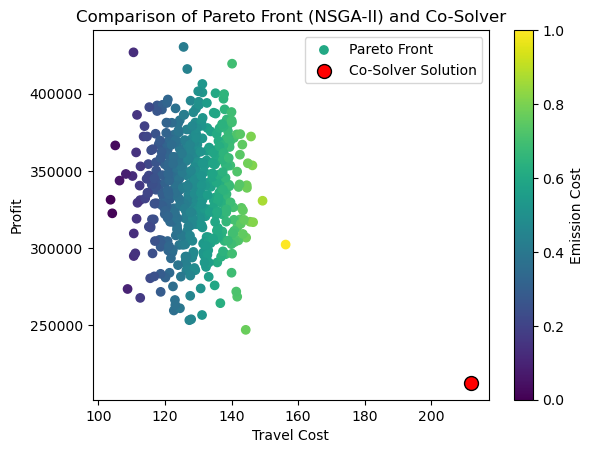

In [17]:
import matplotlib.pyplot as plt

def plot_pareto_front(pareto_solutions, co_solver_solution):
    pareto_profits = [sol[0] for sol in pareto_solutions]
    pareto_travel_costs = [sol[1] for sol in pareto_solutions]
    pareto_emission_costs = [sol[2] for sol in pareto_solutions]

    co_profit, co_travel_cost, co_emission_cost = co_solver_solution

    plt.scatter(pareto_travel_costs, pareto_profits, c=pareto_emission_costs, cmap="viridis", label="Pareto Front")
    plt.scatter([co_travel_cost], [co_profit], color="red", label="Co-Solver Solution", marker="o", edgecolors="black", s=100)
    plt.colorbar(label="Emission Cost")
    plt.xlabel("Travel Cost")
    plt.ylabel("Profit")
    plt.title("Comparison of Pareto Front (NSGA-II) and Co-Solver")
    plt.legend()
    plt.show()

co_solver_solution = (co_best_profit, sum(distances[co_best_route[i]][co_best_route[i + 1]] for i in range(len(co_best_route) - 1)),
                      sum(emissions_per_km * distances[co_best_route[i]][co_best_route[i + 1]] for i in range(len(co_best_route) - 1)))
plot_pareto_front(pareto_solutions, co_solver_solution)
